This can be run [run on Google Colab using this link](https://colab.research.google.com/github/NEU-Silicon-Valley/CS7150-CA2/blob/main/CA2.2_Convolutions.ipynb)

# Toeplitz Convolution in 1D and 2D: Padding, Shifts, and Parameter Counting

In this notebook, we:
1. Demonstrate 1D convolution with a **Toeplitz** matrix.
2. Define and test **equivariance** over integer shifts.
3. See how **padding** changes the output size and affects equivariance.
4. Move to a **2D** case, expressed using flattening, and replicate the convolution via an explicitly filled `Linear` layer in **block Topelitz** form.
5. Wrap up with an exercise on **parameter counts**:
   - Full linear dimension,
   - Nonzero Toeplitz entries,
   - Actual number of kernel parameters.

In this notebook we are doing no optimization, so we disable gradients.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

## Part 1: 1D Convolution

We’ll do an unpadded 1D convolution:
- Input length = **10** (mostly zeros at edges).
- A size-3 kernel.
- **No bias** in the convolution.

Given an input vector
$$
x = \bigl[x_0,\, x_1,\, \dots,\, x_{N-1}\bigr] \in \mathbb{R}^{N}
$$

and a kernel (filter)

$$
w = \bigl[w_0,\, w_1,\, \dots,\, w_{K-1}\bigr] \in \mathbb{R}^K,
$$

the unpadded 1D convolution produces an output

$$
y \in \mathbb{R}^{\,N-K+1}
$$

whose $n$-th entry is:

$$
y_n \;=\; \sum_{r=0}^{K-1} \, w_r \,\cdot\, x_{\,n + r}
\quad \text{for} \quad n = 0,\,1,\,\ldots,\,N-K.
$$



### 1.2 Creating and Filling the Conv1d Kernel

Let’s define a small kernel, e.g.\ $w = [1,\,1,\,-2]$ within a PyTorch `Conv1d` layer called `conv1d_layer`, and apply it to a small sequence of \(N=10\) data items in the vector `x_1d`.


In [3]:
# Our 1D input: shape (channels=1, length=10)
x_1d = torch.tensor([[0.,0.,1.,2.,3.,4.,5.,6.,7.,0.]])
print("x_1d shape:", x_1d.shape)
print("x_1d:", x_1d)

# Conv1d with kernel_size=3, out_channels=1, no bias.
conv1d_layer = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, bias=False)

# Manually set the kernel to [1,1,-2]
with torch.no_grad():
    # We'll do something like conv1d_layer.weight[0,0] = torch.tensor([1.,2.,1.])
    conv1d_layer.weight[0,0] = torch.tensor([1., 1., -2.])

print("Conv1D kernel:", conv1d_layer.weight)
print()

# Forward pass (valid convolution -> output length = 10-3+1 = 8)
y_1d_conv = conv1d_layer(x_1d)
print("Output shape:", y_1d_conv.shape)
print("Output:", y_1d_conv)

x_1d shape: torch.Size([1, 10])
x_1d: tensor([[0., 0., 1., 2., 3., 4., 5., 6., 7., 0.]])
Conv1D kernel: Parameter containing:
tensor([[[ 1.,  1., -2.]]], requires_grad=True)

Output shape: torch.Size([1, 8])
Output: tensor([[-2., -3., -3., -3., -3., -3., -3., 13.]])


In the unpadded case, the output length is the input length minus the kernel size plus one.  In this case, that is:

$$N - K + 1 = 10 - 3 + 1 = \fbox{8}$$




### 1.3 Topelitz matrix equivalent

A convolution is a linear operation, which means it is equivalent to multiplying by a single simple matrix.

The needed form of the matrix is **Toeplitz matrix**, which is a matrix in which each descending diagonal from left to right is constant. For **1D convolution** with a kernel $w$ of length $K$, and an input of length $N$, the unpadded convolution output has length $N-K+1$. Denote these as:

$$
x = [x_0, x_1, x_2, \dots, x_{N-1}]^T,\quad
w = [w_0, w_1, \dots, w_{K-1}],\quad
y = [y_0, y_1, \dots, y_{N-K}]^T.
$$

The 1D convolution is:
$$
y[n] = \sum_{k=0}^{K-1} w_k \cdot x_{n+k},\quad n = 0,1,\dots, N-K.
$$
We can encode this in a matrix multiplication:
$$
y = T\,x,
$$
where \(T\) is a \((N-K+1) \times N\) **Toeplitz** matrix of the form:
$$
T = \begin{bmatrix}
w_0 & w_1 & w_2 & \dots & w_{K-1} & 0      & 0 & \dots \\
0   & w_0 & w_1 & \dots & w_{K-2} & w_{K-1} & 0 & \dots \\
\vdots &   &  & \ddots &   &  &  &  \\
0 & 0 & 0 & \dots & w_0 & w_1 & \dots & w_{K-1}
\end{bmatrix}.
$$
All rows are **shifted** copies of the same kernel, implying **weight sharing**. A **generic** $(N-K+1) \times N$ matrix would have $N-K+1 \times N$ degrees of freedom, but Toeplitz structure means we only have **$K$ free parameters**.


In our case, since the input is 10-dimesional and the output is 8-dimensonal,

$$
\text{weight} \in \mathbb{R}^{8 \times 10}, \quad y = \text{weight} \cdot x.
$$

We only need **3** unique weights $(w_0, w_1, w_2)$ repeated across the rows.


**Exercise**: fill in the Toeplitz matrix equivalent to the convolution in section 1.2.

In [4]:
linear_layer = nn.Linear(in_features=10, out_features=8, bias=False)
linear_layer.weight[...] = torch.Tensor([
    ## PROVIDE YOUR ANSWERS HERE
    [  1.,  1., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
    [  0.,  1.,  1., -2.,  0.,  0.,  0.,  0.,  0.,  0.],
    [  0.,  0.,  1.,  1., -2.,  0.,  0.,  0.,  0.,  0.],
    [  0.,  0.,  0.,  1.,  1., -2.,  0.,  0.,  0.,  0.],
    [  0.,  0.,  0.,  0.,  1.,  1., -2.,  0.,  0.,  0.],
    [  0.,  0.,  0.,  0.,  0.,  1.,  1., -2.,  0.,  0.],
    [  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -2.,  0.],
    [  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -2.],
]);

print("Linear layer with parameters:", linear_layer.weight.shape)
print()

y_linear = linear_layer(x_1d)
print("Linear output shape:", y_linear.shape)
print("Linear output:      ", y_linear)

print("Compare to conv out:", y_1d_conv)
print("Difference:", F.mse_loss(y_1d_conv, y_linear).item())

Linear layer with parameters: torch.Size([8, 10])

Linear output shape: torch.Size([1, 8])
Linear output:       tensor([[-2., -3., -3., -3., -3., -3., -3., 13.]])
Compare to conv out: tensor([[-2., -3., -3., -3., -3., -3., -3., 13.]])
Difference: 0.0


If all goes well, the difference should be near 0.

### 1.2 Equivariance

Let’s define a quick `make_shift(n)` function and test the equivariance of unpadded convolutions

In [5]:
def make_shift(n):
    def shift_function(x):
        """
        Shift the 1D tensor by n steps.
        We'll keep the same length, so we lose data at one boundary
        and add zeros at the other.
        n>0 => shift right, n<0 => shift left.
        """
        L = x.shape[-1]
        zeros = torch.zeros_like(x[..., 0:abs(n)])
        if n > 0:
            return torch.cat([zeros, x[..., :-n]], dim=-1)
        elif n < 0:
            return torch.cat([x[..., -n:], zeros], dim=-1)
        else:
            return x
    return shift_function


A function \(f\) is **equivariant** to a transformation $\tau$ if:
$$
f(\tau(x)) \;=\; \tau\bigl(f(x)\bigr).
$$

In the case of **shift** in 1D, $\tau$ can shift the data by $n$ steps, and equivariance means that when the input is shifted by some amount, the convolution output should be shifted accordingly.

**Exercise:** Modify the following code to test equivariance with respect to various shifts and then report your findings.

In [6]:
# Quick test of equivariance:
tau = make_shift(1)

print("Original input x_1d:  ", x_1d)
print("Shifted input:        ", tau(x_1d))
print("Shifted output:       ", tau(y_1d_conv))
print("Conv of shifted input:", conv1d_layer(tau(x_1d)))  # FILL THIS IN

Original input x_1d:   tensor([[0., 0., 1., 2., 3., 4., 5., 6., 7., 0.]])
Shifted input:         tensor([[0., 0., 0., 1., 2., 3., 4., 5., 6., 7.]])
Shifted output:        tensor([[ 0., -2., -3., -3., -3., -3., -3., -3.]])
Conv of shifted input: tensor([[ 0., -2., -3., -3., -3., -3., -3., -3.]])


Test a range of shifts from -5 to 5.

Is the padded convolution equivariant with respect to $\tau$?

**Student**: After testing on this output, equivariance holds for this input when the shifts by $i$ are in the set: $\fbox{set: {-2, -1, 0}.}$.
- Shift 0: No shift, trivially equivariant
- Shift -1: Moves data left by 1, but the trailing zero at position 9 means no information is lost
- Shift -2: Moves data left by 2, both trailing zeros (positions 8-9) mean no information is lost
- Shifts ≤ -3: Start losing non-zero values from position 7, 6, etc.
- Shifts ≥ 1: The zeros at the beginning get shifted into the convolution window, changing the result.



---
## Part 2: Adding Padding=1 in 1D

Now let's see how **padding** affects the output shape and equivariance. If we do `padding=1` with a `Conv1d`, a kernel of length=3, and input length=10, the output length is now larger (since the kernel can start at the left edge with a pad).

### 2.1 Padded Conv1d


In [7]:
# We'll re-create a new conv1d for the padded case.
conv1d_pad = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)

conv1d_pad.weight[0,0] = torch.tensor([1.,1.,-2.])

# This should produce an output of length=10.
y_1d_pad = conv1d_pad(x_1d)
print("Padding=1 -> output shape:", y_1d_pad.shape)
print("Output:", y_1d_pad)


Padding=1 -> output shape: torch.Size([1, 10])
Output: tensor([[ 0., -2., -3., -3., -3., -3., -3., -3., 13.,  7.]])


In padded case, the output length is the input length minus the kernel size plus twice the padding (assuming padding on both left and right), plus one.  In this case, that is:

$$N - K + 2P + 1 = 10 - 3 + 2 + 1 = \fbox{10}$$

### 2.2 Toeplitz Matrix for the Padded Case

Now the output is length=10, and the input is length=10, so we can do a `Linear(10,10, bias=False)` and fill it with the Toeplitz pattern for a 3-tap kernel **plus** the notion of 1 padding on each side. The Toeplitz approach for padding is effectively a 10×10 matrix with some of the corners hosting only a portion of the kernel.

**Exercise**: Fill in the 10×10 so that it matches `padding=1` semantics.


In [8]:
linear_layer_pad = nn.Linear(in_features=10, out_features=10, bias=False)
linear_layer_pad.weight[...] = torch.Tensor([
    [  1., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
    [  1.,  1., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
    [  0.,  1.,  1., -2.,  0.,  0.,  0.,  0.,  0.,  0.],
    [  0.,  0.,  1.,  1., -2.,  0.,  0.,  0.,  0.,  0.],
    [  0.,  0.,  0.,  1.,  1., -2.,  0.,  0.,  0.,  0.],
    [  0.,  0.,  0.,  0.,  1.,  1., -2.,  0.,  0.,  0.],
    [  0.,  0.,  0.,  0.,  0.,  1.,  1., -2.,  0.,  0.],
    [  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -2.,  0.],
    [  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -2.],
    [  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
]);

print("Linear layer with parameters:", linear_layer_pad.weight.shape)
print()

y_linear_pad = linear_layer_pad(x_1d)
print("Linear output shape:", y_linear_pad.shape)
print("Linear output:      ", y_linear_pad)

print("Compare to conv out:", y_1d_pad)
print("Difference:", F.mse_loss(y_1d_pad, y_linear_pad).item())

Linear layer with parameters: torch.Size([10, 10])

Linear output shape: torch.Size([1, 10])
Linear output:       tensor([[ 0., -2., -3., -3., -3., -3., -3., -3., 13.,  7.]])
Compare to conv out: tensor([[ 0., -2., -3., -3., -3., -3., -3., -3., 13.,  7.]])
Difference: 0.0


If the difference is near zero, we’ve matched the padded convolution.

### 2.3 Check Equivariance with Padding=1
We can again try shifting the input in the range \(-5..5\). With padding, the output is always length=10. But does that make it fully shift-equivariant?

In practice, the *artificial* zeros at the edges might still cause boundary effects that break perfect equivariance once the shift is large enough.

> **Student**: Test equivariance of the padded convolutoin and report your results here. Where does it break?

In [11]:
# Quick test of equivariance:
tau = make_shift(1)

print("Original input x_1d:  ", x_1d)
print("Shifted input:        ", tau(x_1d))
print("Shifted output:       ", tau(y_1d_pad))
print("Conv of shifted input:", conv1d_pad(tau(x_1d))) # FILL THIS IN

Original input x_1d:   tensor([[0., 0., 1., 2., 3., 4., 5., 6., 7., 0.]])
Shifted input:         tensor([[0., 0., 0., 1., 2., 3., 4., 5., 6., 7.]])
Shifted output:        tensor([[ 0.,  0., -2., -3., -3., -3., -3., -3., -3., 13.]])
Conv of shifted input: tensor([[ 0.,  0., -2., -3., -3., -3., -3., -3., -3., 13.]])


Test a range of shifts from -5 to 5.

Is the padded convolution equivariant with respect to $\tau$?

**Student**: After testing on this output, equivariance holds for this input when the shifts by $i$ are in the set: $\fbox{{-1,0,1}}$.



---
# Part 3: 2D Convolution via Block-Toeplitz Matrices

In 2D, the equivalent **Toeplitz** concept generalizes to **Block-Toeplitz** form. If your kernel is $R\times S$, and the input image is $H\times W$, then the valid convolution output is $(H - R + 1) \times (W - S + 1)$. If you **flatten** the input image (length $H\times W$) and flatten the output (length $(H - R + 1)(W - S + 1)$), you can create a big matrix $T$ of size $(H - R + 1)(W - S + 1) \times (H\times W)$. Each row in that matrix picks out **one** $R\times S$ patch from the image.


### 3.1 A 2d Binary Input Image
Let’s create a 4×5 binary image, define a 3×3 kernel, and compare:
1. **PyTorch** 2D convolution
2. A fully connected (`Linear`) layer that we fill with the **block-Toeplitz** pattern.
3. Confirm they match, then **visualize** both outputs.
With 4×5 and  3×3 **unpadded** kernel, the convolution yields output shape 2×3.


Image shape: 4x5
tensor([[1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 1.],
        [1., 0., 0., 1., 0.],
        [1., 1., 1., 0., 0.]])


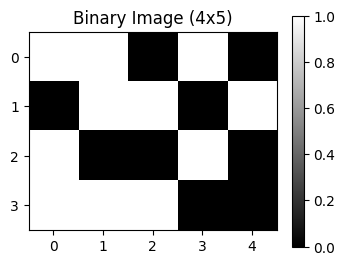

x_2d shape: torch.Size([1, 1, 4, 5])


In [12]:
img_2d = torch.tensor([
    [1,1,0,1,0],
    [0,1,1,0,1],
    [1,0,0,1,0],
    [1,1,1,0,0]
], dtype=torch.float)

print("Image shape: 4x5")
print(img_2d)
plt.figure(figsize=(4,3))
plt.imshow(img_2d, cmap='gray')
plt.title("Binary Image (4x5)")
plt.colorbar()
plt.show()

x_2d = img_2d.unsqueeze(0).unsqueeze(0)  # (1,1,4,5)
print("x_2d shape:", x_2d.shape)

### 3.2 Define a 3×3 Kernel and Convolve
The valid output shape is (4-3+1)×(5-3+1) = 2×3.


2D conv output shape: torch.Size([1, 1, 2, 3])
Output: tensor([[[[ 4., -5.,  0.],
          [-3.,  6.,  0.]]]])


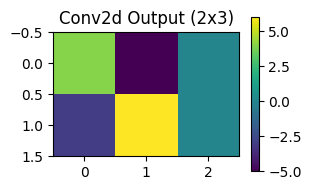

In [13]:
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
with torch.no_grad():
    # Let's define some pattern for the 3x3 kernel:
    conv2d.weight[0,0] = torch.tensor([
        [ 2.,  1., -2.],
        [-3., -1.,  1.],
        [ 1.,  1., -1.]
    ])

y_2d = conv2d(x_2d)
print("2D conv output shape:", y_2d.shape)  # (1,1,2,3)
print("Output:", y_2d)

plt.figure(figsize=(3,2))
plt.imshow(y_2d[0,0,:,:], cmap='viridis')
plt.title("Conv2d Output (2x3)")
plt.colorbar()
plt.show()

### 3.3 Flattening the image and expressing the convolution as Toeplitz

If we flatten the **4×5** input (2 elements) in **row-major** order and flatten the **2x3** output (6 elements).

$$
\text{vec}(X) = [\,x_{0,0},\; x_{0,1},\;\dots,\; x_{0,4},\; x_{1,0},\dots, x_{3,4}\,]^\top \in \mathbb{R}^{20}.
$$

$$
\text{vec}(Y) = [\,y_{0,0},\; y_{0,1},\; y_{0,2},\; y_{1,0},\; y_{1,1},\; y_{1,2}\,]^\top \in \mathbb{R}^{6}.
$$

Then a fully connected layer from 20 to 6 can replicate the same operation if we fill it in a **Toeplitz** pattern of size 6x20.
- Each row (in the 6) picks out a certain 3×3 patch from the 20.
- The kernel’s 9 coefficients get placed in the right positions in that row.

For example, in the example above, the first row would contain

`[  2.,  1., -2.,  0.,  0., -3., -1.,  1.,  0.,  0.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]'
`


> So, of all the many parameters of `Linear(in_features=20, out_features=6, bias=False)`, we only only want **9** unique parameters repeated in positions that correspond to the same kernel value.

### 3.4 Exercise: Fill a `Linear(20,6)` with the block Toeplitz Layout
We create a `nn.Linear(20, 6, bias=False)`. Then for each output position `(r,c)`, we place the kernel into the correct 9 positions referencing `(r+dr, c+dc)` in the input.  To figure out this form, it is helpful to understand which row and which column in the full matrix corresponds to each 3x3 patch in the original image.


fc2d output (2x3):
 tensor([[ 4., -5.,  0.],
        [-3.,  6.,  0.]])
Difference vs conv2d: tensor([[0., 0., 0.],
        [0., 0., 0.]])


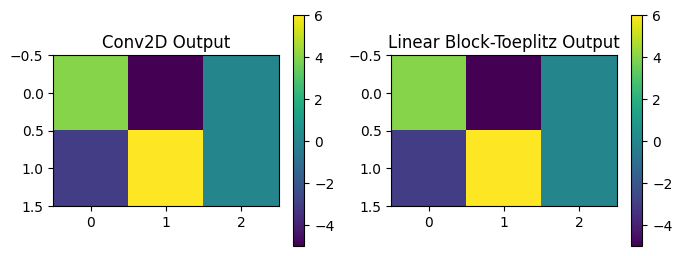

In [14]:
fc2d = nn.Linear(in_features=20, out_features=6, bias=False)
fc2d.weight[...] = torch.Tensor([
    ## PROVIDE YOUR ANSWERS HERE
    # Row 0: Output position (0,0)input (0:3, 0:3)
    [ 2., 1.,-2., 0., 0.,-3.,-1., 1., 0., 0., 1., 1.,-1., 0., 0., 0., 0., 0., 0., 0.],
    # Row 1: Output position (0,1) - i/p (0:3, 1:4)
    [ 0., 2., 1.,-2., 0., 0.,-3.,-1., 1., 0., 0., 1., 1.,-1., 0., 0., 0., 0., 0., 0.],
    # Row 2: Output position (0,2) i/p (0:3, 2:5)
    [ 0., 0., 2., 1.,-2., 0., 0.,-3.,-1., 1., 0., 0., 1., 1.,-1., 0., 0., 0., 0., 0.],
    # Row 3: Output position (1,0)-i/p (1:4, 0:3)
    [ 0., 0., 0., 0., 0., 2., 1.,-2., 0., 0.,-3.,-1., 1., 0., 0., 1., 1.,-1., 0., 0.],
    # Row 4: Output position (1,1)inpiut (1:4, 1:4)
    [ 0., 0., 0., 0., 0., 0., 2., 1.,-2., 0., 0.,-3.,-1., 1., 0., 0., 1., 1.,-1., 0.],
    # Row 5: Output position (1,2) ii/p (1:4, 2:5)
    [ 0., 0., 0., 0., 0., 0., 0., 2., 1.,-2., 0., 0.,-3.,-1., 1., 0., 0., 1., 1.,-1.],
]);

# Multiply x_2d flattened
x_2d_flat = x_2d.view(1,20)
y_fc2d = fc2d(x_2d_flat)  # shape (1,6)
y_fc2d_reshaped = y_fc2d.view(2,3)

print("fc2d output (2x3):\n", y_fc2d_reshaped)
diff_2d = y_fc2d_reshaped - y_2d[0,0]
print("Difference vs conv2d:", diff_2d)

# Visual comparison
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(y_2d[0,0].detach(), cmap='viridis')
plt.title("Conv2D Output")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(y_fc2d_reshaped.detach(), cmap='viridis')
plt.title("Linear Block-Toeplitz Output")
plt.colorbar()
plt.show()

If two operations look identical, we have successfully replicated the 2D convolution with a single large matrix that repeats the 9 kernel parameters in a block-Toeplitz pattern.

---
## Part 4: Parameter Counts

Finally, let’s highlight the massive difference in parameter counts:

**Student** fill in the counts.

1. **Full Linear**: (out_features) × (in_features). The number of parameters in a the full linear operation going from 20 dimensions to 2 is $\fbox{120 params}$.
2. **Block-Toeplitz**: Each **non-zero** entry in the block Toeplitz matrix corresponds to a multiplication operation that needs to be done during convolution.  The number of nonzero entries in the block Toeplitz matrix above is $\fbox{54 operatins}$.
3. **Convolution Kernel**: Each entry block Toplitz matrix corresponds to one of the few **unique** parameters in the convolutional kernel.  The number of parameters in the convolutional kernel in this exercise was $\fbox{9}$.

Although a convolution is does not add any new computaional power beyond a linear operation, it provides advantages through **sparsity**, which dramatically reduces the amount of computation needed to process the input data, and through **weight sharing**, which dramatically reduces the size of the parameter space that needs to be searched by the optimization process.


---
## Conclusion

We have now:
- Demonstrated **Toeplitz** and **block-Toeplitz** construction for valid convolution in 1D and 2D.
- Seen how **padding** changes the dimension and partial equivariance.
- Highlighted the difference between a fully dense linear map and a convolution with **weight sharing**.